In [1]:
import numpy as np
import tensorflow as tf
import IPython
import time
import matplotlib.pyplot as plt
import functools
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from jupyterthemes import jtplot
import mitdeeplearning as mdl
jtplot.style()

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
Y_train = pd.read_csv('Y_train_surge.csv')
Y_train = Y_train.to_numpy()
surge_input = Y_train[:,1:21].astype(np.float32)

data = np.load("X_train_surge_new.npz")
slp = data["slp"].astype(np.float32) #the 40 sea-level pressure (SLP) fields, encoded in images of size (41, 41).

In [4]:
data_test = np.load("X_test_surge_new.npz")
slp_test =  data_test["slp"].astype(np.float32)

In [5]:
### SLP ###
shape = slp.shape
mean_slp = np.mean(slp)
std_slp = np.std(slp)
slp = np.reshape((slp-mean_slp)/std_slp,(shape[0],shape[1],shape[2],shape[3],1))
shape = slp_test.shape
slp_test = np.reshape((slp_test-mean_slp)/std_slp,(shape[0],shape[1],shape[2],shape[3],1))

#### SURGE #####
mean_surge = np.mean(surge_input)
std_surge = np.std(surge_input)
surge_input = (surge_input-mean_surge)/std_surge

In [6]:
#np.random.seed(0)
## indexes for train and test set
train_set_idx = np.random.choice(slp.shape[0],int(slp.shape[0]*0.9),replace = False)
test_set_idx = np.delete(np.arange(slp.shape[0]),train_set_idx)

## TRAIN SET
train_slp = slp[train_set_idx]
train_surge = surge_input[train_set_idx]
### TEST SET
test_slp = slp[test_set_idx]
test_surge = surge_input[test_set_idx]


print(train_slp.shape)
print(train_surge.shape)

(5039, 40, 41, 41, 1)
(5039, 20)


In [7]:
def custom_loss_function(y, y_recon,weight=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]):
    weight = tf.convert_to_tensor(weight, dtype=tf.float32)
    substract = tf.math.square(y-y_recon)
    loss = tf.reduce_mean(tf.math.multiply(weight,substract))
    return loss

In [8]:
n_filters = 12 # base number of convolutional filters, same as standard CNN

def make_standard_cnn(n_outputs=10):
  Conv3D = functools.partial(tf.keras.layers.Conv3D, activation='relu')
  Conv2D = functools.partial(tf.keras.layers.Conv2D, activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  ConvLSTM2D = functools.partial(tf.keras.layers.ConvLSTM2D)
  Maxpool = tf.keras.layers.MaxPool2D
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='tanh')

  model = tf.keras.Sequential([
    ConvLSTM2D(filters=int(1*n_filters), kernel_size=(3,3)),
    Maxpool(),
    
    Conv2D(filters=int(2.5*n_filters), kernel_size=3), 
    Maxpool(),
    

    
    Flatten(),
    Dense(80),
    tf.keras.layers.Dropout(rate=0.25),
    Dense(100),
    tf.keras.layers.Dropout(rate=0.5),
    Dense(n_outputs, activation=None), 
  ])
  return model


In [9]:
model = make_standard_cnn()
model.build(input_shape = train_slp.shape)
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2), 
              loss='MeanSquaredError',
              metrics=['RootMeanSquaredError'
                      ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (5039, 39, 39, 24)        21696     
                                                                 
 max_pooling2d (MaxPooling2D  (5039, 19, 19, 24)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (5039, 17, 17, 36)        7812      
                                                                 
 max_pooling2d_1 (MaxPooling  (5039, 8, 8, 36)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (5039, 2304)              0         
                                                                 
 dense (Dense)               (5039, 80)                1

In [34]:
class custom_CNN(tf.keras.Model):
    def __init__(self, n_output=10):
        super(custom_CNN, self).__init__()
        self.n_output= n_output
        self.weight = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
        self.cnn = make_standard_cnn()

  # The call function will be used to pass inputs x through the core CNN
    def call(self, x): 
        reconstruction = self.cnn(x)
        return reconstruction

  # Predict face or not face logit for given input x
    def evaluate(self, x_eval,y_eval):
        y_pred = self.cnn(x_eval)
        weighted_mse = custom_loss_function(y_pred, y_eval,self.weight)
        #print(f'Evaluation Loss : {weighted_mse}')
        return weighted_mse
    
    def evaluate_one_by_one(self, x_eval,y_eval,batch_size):
        mse_total = []
        batch_size = batch_size*4
        for i in tqdm(range(x_eval.shape[0]// batch_size)):
            end_index_eval = min(x_eval.shape[0],(i+1)*batch_size)
            batch = np.arange(i*batch_size,end_index_eval)
            mse_total.append(self.evaluate(x_eval[batch],y_eval[batch]))        
        return sum(mse_total)/len(mse_total)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
def train_step(x, y,cnn,optimizer):
    with tf.GradientTape() as tape:
        y_recon = cnn(x)
        loss = custom_loss_function(y, y_recon)
    grads = tape.gradient(loss, cnn.trainable_variables)

    optimizer.apply_gradients(zip(grads, cnn.trainable_variables))
    return loss,y_recon

Starting epoch 25/25 and loss1 : 0.33486899733543396 and eval_loss1 : 0             


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.73it/s]


ValueError: x and y must have same first dimension, but have shapes (12,) and (13,)

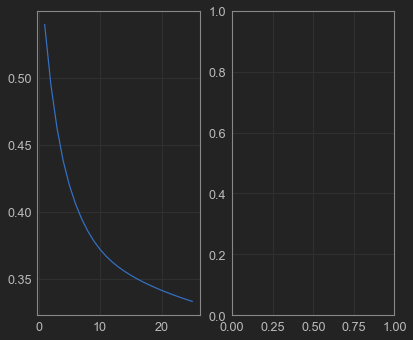

In [39]:
# Hyperparameters
batch_size = 16
learning_rate1 = 0.8e-3
num_epochs1 = 70
optimizer1 = tf.keras.optimizers.SGD(learning_rate1)

#data saving
loss_history1 = []
eval_loss_hisotry1 = []
total_loss1 = 0

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def train_step1(x, y,cnn):
    with tf.GradientTape() as tape:
        # Feed input x into cnn. Note that this is using the CNN call function!
        y_recon = cnn(x)
        loss = custom_loss_function(y, y_recon)
    grads = tape.gradient(loss, cnn.trainable_variables)
    optimizer1.apply_gradients(zip(grads, cnn.trainable_variables))
    return loss,y_recon

total_eval_loss1 = 0    
cnn1 = custom_CNN()
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
        # For the first TOWN
for i in range(num_epochs1):
    #learning rate decay
    """if num_epochs1 > 13 : 
        cosine_decay = 0.7 * (1 + tf.math.cos(np.pi * 4 / 13))
        learning_rate1 = learning_rate1*cosine_decay
        optimizer1 = tf.keras.optimizers.SGD(learning_rate1)"""

    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{} and loss1 : {} and eval_loss1 : {} \
            ".format(i+1, num_epochs1,total_loss1,total_eval_loss1))
    # get a batch of training data and compute the training step
    total_loss1 = 0
    
    for j in tqdm(range(train_slp.shape[0] // batch_size)):
        end_index = min(train_slp.shape[0]-1,(j+1)*batch_size)
            # load a batch of data
        (x, y) = (train_slp[j*batch_size:end_index],train_surge[j*batch_size:end_index,:10])
        # loss optimization
        loss1,y_recon = train_step1(x, y,cnn1)
        total_loss1 += loss1 
    
    if i %2 == 0:
        total_eval_loss1 = 0
        total_eval_loss1 = cnn1.evaluate_one_by_one(test_slp,test_surge[:,:10],batch_size)
        eval_loss_hisotry1.append(total_eval_loss1)
    total_loss1 = total_loss1/(train_slp.shape[0] // batch_size)
    loss_history1.append(total_loss1)
                     
#PLOT
plt.subplot(1,2,1)
plt.plot(np.linspace(1,num_epochs1,num_epochs1),loss_history1)
plt.subplot(1,2,2)
plt.plot(np.linspace(1,len(eval_loss_history1),len(eval_loss_history1)),eval_loss_history1)

In [51]:
surge_train2=np.copy(train_surge[:,10:])
surge_train2.shape

(5039, 10)

In [46]:
#Hyperparameters
learning_rate2 = 1e-3
num_epochs2= 50
optimizer2 = tf.keras.optimizers.SGD(learning_rate2)

#Saving DAta
loss_history2 = []
eval_loss_hisotry2 = []
total_loss2 = 0

@tf.function
def train_step2(x, y,cnn):
    with tf.GradientTape() as tape:
            # Feed input x into cnn. Note that this is using the CNN call function!
        y_recon = cnn(x)
        loss = custom_loss_function(y, y_recon)
    grads = tape.gradient(loss, cnn.trainable_variables)
    optimizer2.apply_gradients(zip(grads, cnn.trainable_variables))
    return loss,y_recon

    
# For the SECOND TOWN 
cnn2 = custom_CNN()
total_eval_loss2 = 0
eval_loss_hisotry2 = []
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i in range(num_epochs2):
    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{} and loss2 : {} and eval_loss2 : {} \
    ".format(i+1, num_epochs2,total_loss2,total_eval_loss2))
    total_loss2 = 0

          # get a batch of training data and compute the training step
    for j in tqdm(range(train_slp.shape[0] // batch_size)):
        end_index = min(train_slp.shape[0]-1,j+batch_size)
        # load a batch of data
        (x, y) = (train_slp[j:end_index],surge_train2[j:end_index])
        # loss optimization
        loss2,y_recon = train_step2(x, y,cnn2)
        total_loss2 += loss2 
        
    if i %2 == 0:
        total_eval_loss2 = 0
        total_eval_loss2 = cnn2.evaluate_one_by_one(test_slp,test_surge[:,10:],batch_size)
        eval_loss_hisotry2.append(total_eval_loss2)
    total_loss2 = total_loss2/(train_slp.shape[0] // batch_size)
    loss_history2.append(total_loss2)

plt.subplot(1,2,1)
plt.plot(np.linspace(1,num_epochs2,num_epochs2),loss_history2)
plt.subplot(1,2,2)
plt.plot(np.linspace(1,num_epochs2,num_epochs2),eval_loss_hisotry2)

Starting epoch 29/50 and loss2 : 0.30752265453338623 and eval_loss2 : 0.39946284890174866     


 26%|████████████████████▉                                                            | 81/314 [00:35<01:41,  2.29it/s]


KeyboardInterrupt: 

In [48]:
print(cnn1.evaluate_one_by_one(test_slp,test_surge[:,:10],batch_size))
print(cnn2.evaluate_one_by_one(test_slp,test_surge[:,10:],batch_size))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


tf.Tensor(0.34307757, shape=(), dtype=float32)


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.80it/s]

tf.Tensor(0.44989896, shape=(), dtype=float32)


In [ ]:
y_pred1 = cnn1(slp_test).numpy()
y_pred2 = cnn2(slp_test).numpy()
y_pred = np.concatenate((y_pred1,y_pred2),axis=1)
y_pred = (y_pred*std_surge)+mean_surge
print(y_pred.shape)
print(y_pred[0,0],y_pred1[0,0],y_pred[0,10],y_pred2[0,0])

In [ ]:
plt.figure(figsize=(20,8))
random_inds = np.random.choice(y_pred.shape[0],4)
print(random_inds)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    image_ind = random_inds[i]
    plt.plot(y_pred[image_ind,:])
    plt.xlabel('Line '+ str(image_ind)+ ' started at ')

y_columns = [f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)]
y_test_benchmark = pd.DataFrame(data=y_pred, columns=y_columns, index=data_test['id_sequence'])
y_test_benchmark.to_csv('surge_predicted_custom_CNN.csv', index_label='id_sequence', sep=',')